In [1]:
import gc
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import GroupKFold, GroupShuffleSplit, StratifiedGroupKFold
from sklearn.metrics import precision_recall_curve, auc

In [2]:
train = pd.read_parquet('/kaggle/input/avito-merged-dataset/train_df.parquet')
test = pd.read_parquet('/kaggle/input/avito-merged-dataset/test_df.parquet')

In [3]:
len(train), len(test)

(1879555, 500000)

In [4]:
to_drop = [
    'category_level_1_1', 'category_level_1_2',
    'category_level_2_1', 'category_level_2_2',
    'category_level_3_1', 'category_level_3_2',
    'category_level_4_1', 'category_level_4_2',
]

In [5]:
train[to_drop] = train[to_drop].fillna('none')

train['unique_cat_1'] = train['category_level_1_1'] + train['category_level_1_2']
train['unique_cat_2'] = train['category_level_2_1'] + train['category_level_2_2']
train['unique_cat_3'] = train['category_level_3_1'] + train['category_level_3_2']
train['unique_cat_4'] = train['category_level_4_1'] + train['category_level_4_2']

In [6]:
test[to_drop] = test[to_drop].fillna('none')

test['unique_cat_1'] = test['category_level_1_1'] + test['category_level_1_2']
test['unique_cat_2'] = test['category_level_2_1'] + test['category_level_2_2']
test['unique_cat_3'] = test['category_level_3_1'] + test['category_level_3_2']
test['unique_cat_4'] = test['category_level_4_1'] + test['category_level_4_2']

In [7]:
train.drop(columns=to_drop, axis=1, inplace=True)
gc.collect()

0

In [8]:
test.drop(columns=to_drop, axis=1, inplace=True)
gc.collect()

0

In [9]:
train.drop(columns=['action_date'], inplace=True)

In [10]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                    gc.collect()
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                    gc.collect()
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                    gc.collect()
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
                    gc.collect()
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                    gc.collect()
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                    gc.collect()
                else:
                    df[col] = df[col].astype(np.float64)
                    gc.collect()
        else:
            if df[col].nunique() == 2:
                df[col] = df[col].astype('bool')
            gc.collect()

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    gc.collect()
    
    return df

In [11]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 6513.88 MB
Memory usage after optimization is: 1839.09 MB
Decreased by 71.8%
Memory usage of dataframe is 1728.06 MB
Memory usage after optimization is: 490.67 MB
Decreased by 71.6%


In [12]:
train_clip = pd.read_parquet('/kaggle/input/clip-marqofashionsiglip-marqoecom-top2kaggle/cossim_final_embeddings_train_CLIP.parquet')
test_clip = pd.read_parquet('/kaggle/input/clip-marqofashionsiglip-marqoecom-top2kaggle/cossim_final_embeddings_test_CLIP.parquet')

train_fashionsiglip = pd.read_parquet('/kaggle/input/clip-marqofashionsiglip-marqoecom-top2kaggle/cossim_final_embeddings_fashion_clip_train.parquet')
test_fashionsiglip = pd.read_parquet('/kaggle/input/clip-marqofashionsiglip-marqoecom-top2kaggle/cossim_final_embeddings_fashion_clip_test.parquet')

train_ecom = pd.read_parquet('/kaggle/input/clip-marqofashionsiglip-marqoecom-top2kaggle/cossim_final_embeddings_ecomm_train.parquet')
test_ecom = pd.read_parquet('/kaggle/input/clip-marqofashionsiglip-marqoecom-top2kaggle/cossim_final_embeddings_ecomm_test.parquet')

# train_top2kaggle = pd.read_parquet('/kaggle/input/clip-marqofashionsiglip-marqoecom-top2kaggle/cossim_final_top2_kaggle_train.parquet')
# test_top2kaggle = pd.read_parquet('/kaggle/input/clip-marqofashionsiglip-marqoecom-top2kaggle/cossim_final_top2_kaggle_test.parquet')

In [13]:
train_clip = train_clip.sort_values(by=['variantid_1', 'variantid_2'])
test_clip = test_clip.sort_values(by=['variantid_1', 'variantid_2'])

train_fashionsiglip = train_fashionsiglip.sort_values(by=['variantid_1', 'variantid_2'])
test_fashionsiglip = test_fashionsiglip.sort_values(by=['variantid_1', 'variantid_2'])

train_ecom = train_ecom.sort_values(by=['variantid_1', 'variantid_2'])
test_ecom = test_ecom.sort_values(by=['variantid_1', 'variantid_2'])

# train_top2kaggle = train_top2kaggle.sort_values(by=['variantid_1', 'variantid_2'])
# test_top2kaggle = test_top2kaggle.sort_values(by=['variantid_1', 'variantid_2'])

In [14]:
train = train.sort_values(by=['variantid_1', 'variantid_2'])
test = test.sort_values(by=['variantid_1', 'variantid_2'])

In [15]:
train['clip_cosine_sim'] = train_clip['cosine_sim']
test['clip_cosine_sim'] = test_clip['cosine_sim']

train['fashionsiglip_cosine_sim'] = train_fashionsiglip['cosine_sim']
test['fashionsiglip_cosine_sim'] = test_fashionsiglip['cosine_sim']

train['ecom_cosine_sim'] = train_ecom['cosine_sim']
test['ecom_cosine_sim'] = test_ecom['cosine_sim']

# train['top2kaggle_cosine_sim'] = train_top2kaggle['cosine_sim']
# test['top2kaggle_cosine_sim'] = test_top2kaggle['cosine_sim']

In [16]:
del train_clip, test_clip, train_fashionsiglip, test_fashionsiglip, train_ecom, test_ecom#, train_top2kaggle, test_top2kaggle

In [17]:
berta_cossims_train_part1 = pd.read_parquet('/kaggle/input/berta-pretrained-cossims/berta_cossims_train_part1.parquet')
berta_cossims_train_part2 = pd.read_parquet('/kaggle/input/berta-pretrained-cossims/berta_cossims_train_part2.parquet')
berta_cossims_test = pd.read_parquet('/kaggle/input/berta-pretrained-cossims/berta_cossims_test.parquet')

In [18]:
berta_cossims_train = pd.concat([berta_cossims_train_part1, berta_cossims_train_part2])

In [19]:
len(berta_cossims_train_part1) + len(berta_cossims_train_part2) == len(berta_cossims_train)

True

In [20]:
del berta_cossims_train_part1, berta_cossims_train_part2
gc.collect()

0

In [21]:
berta_cossims_train = berta_cossims_train.sort_values(by=['variantid_1', 'variantid_2'])
berta_cossims_test = berta_cossims_test.sort_values(by=['variantid_1', 'variantid_2'])

In [22]:
train['berta_cossim'] = berta_cossims_train['berta_cossim']
test['berta_cossim'] = berta_cossims_test['berta_cossim']

In [23]:
del berta_cossims_train, berta_cossims_test
gc.collect()

0

In [24]:
train = train.sample(len(train), random_state=42)

In [25]:
train.drop(columns=['variantid_1', 'variantid_2', 'base_title_image', 'cand_title_image'], axis=1, inplace=True)
test.drop(columns=['variantid_1', 'variantid_2', 'base_title_image', 'cand_title_image'], axis=1, inplace=True)

In [26]:
features = [col for col in train.columns if col not in ['group_id', 'is_double']]
target = 'is_double'

In [27]:
cat_features = [
    'is_same_location',
    'is_same_region',
    'category_level_1_match',
    'category_level_2_match',
    'category_level_3_match',
    'category_level_4_match',
    'category_level_3_fillness',
    'category_level_4_fillness',
    'n_images_fillness',
    'unique_cat_1',
    'unique_cat_2',
    'unique_cat_3',
    'unique_cat_4',
]

train[cat_features] = train[cat_features].astype(str)
test[cat_features] = test[cat_features].astype(str)

In [28]:
gc.collect()

0

In [29]:
len(features)

454

In [30]:
# import numpy as np
# from sklearn.model_selection._split import _BaseKFold

# class GroupKFoldShuffle(_BaseKFold):
#     def __init__(self, n_splits=5, *, shuffle=False, random_state=None):
#         super().__init__(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

#     def split(self, X, y=None, groups=None):
#         unique_groups = np.unique(groups)

#         if self.shuffle:
#             np.random.seed(self.random_state)
#             unique_groups = np.random.permutation(unique_groups)

#         split_groups = np.array_split(unique_groups, self.n_splits)

#         for test_group_ids in split_groups:
#             test_mask = np.isin(groups, test_group_ids)
#             train_mask = ~test_mask

#             train_idx = np.where(train_mask)[0]
#             test_idx = np.where(test_mask)[0]

#             yield train_idx, test_idx

In [31]:
gkf = StratifiedGroupKFold(n_splits=5) # GroupKFold(n_splits=5)

models = []
oof_preds = np.zeros(len(train))

for fold, (train_idx, val_idx) in enumerate(gkf.split(train, train[target], groups=train['group_id'])):
    print(f"fold {fold+1}...")
    
    X_train, X_val = train.iloc[train_idx][features], train.iloc[val_idx][features]
    y_train, y_val = train.iloc[train_idx][target], train.iloc[val_idx][target]
    
    model = CatBoostClassifier(
        iterations=50000,
        learning_rate=0.1,
        cat_features=cat_features,
        # auto_class_weights='Balanced',
        eval_metric='PRAUC',
        random_seed=42+fold,
        early_stopping_rounds=500,
        task_type='GPU',
        verbose=100
    )
    
    model.fit(X_train, y_train, eval_set=(X_val, y_val))
    oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
    models.append(model)

    joblib.dump(model, f"catboost_model_fold_{fold+1}.joblib")

    gc.collect()

fold 1...


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.3787121	test: 0.3373481	best: 0.3373481 (0)	total: 6.52s	remaining: 3d 18h 33m 40s
100:	learn: 0.6180691	test: 0.5363128	best: 0.5363128 (100)	total: 24.9s	remaining: 3h 25m 20s
200:	learn: 0.6558560	test: 0.5601619	best: 0.5603374 (198)	total: 43.5s	remaining: 2h 59m 49s
300:	learn: 0.6764239	test: 0.5730231	best: 0.5732405 (298)	total: 1m 2s	remaining: 2h 51m 19s
400:	learn: 0.6903643	test: 0.5791330	best: 0.5791330 (400)	total: 1m 20s	remaining: 2h 46m 41s
500:	learn: 0.7008528	test: 0.5817587	best: 0.5817587 (500)	total: 1m 39s	remaining: 2h 43m 16s
600:	learn: 0.7089169	test: 0.5859233	best: 0.5859519 (599)	total: 1m 57s	remaining: 2h 40m 38s
700:	learn: 0.7156365	test: 0.5900509	best: 0.5900924 (696)	total: 2m 15s	remaining: 2h 38m 36s
800:	learn: 0.7216182	test: 0.5920037	best: 0.5920564 (797)	total: 2m 33s	remaining: 2h 36m 55s
900:	learn: 0.7265306	test: 0.5940334	best: 0.5940334 (900)	total: 2m 51s	remaining: 2h 35m 40s
1000:	learn: 0.7315147	test: 0.5954301	best:

Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.3731270	test: 0.3510409	best: 0.3510409 (0)	total: 183ms	remaining: 2h 32m 22s
100:	learn: 0.6266525	test: 0.5089475	best: 0.5089475 (100)	total: 19s	remaining: 2h 36m 35s
200:	learn: 0.6685463	test: 0.5312921	best: 0.5312933 (199)	total: 38s	remaining: 2h 36m 46s
300:	learn: 0.6891989	test: 0.5427367	best: 0.5427367 (300)	total: 56.5s	remaining: 2h 35m 31s
400:	learn: 0.7031192	test: 0.5480711	best: 0.5480737 (399)	total: 1m 15s	remaining: 2h 34m 37s
500:	learn: 0.7128772	test: 0.5531473	best: 0.5531473 (500)	total: 1m 33s	remaining: 2h 33m 14s
600:	learn: 0.7203765	test: 0.5563473	best: 0.5564797 (597)	total: 1m 51s	remaining: 2h 32m 5s
700:	learn: 0.7272222	test: 0.5577486	best: 0.5577935 (699)	total: 2m 9s	remaining: 2h 31m 26s
800:	learn: 0.7330585	test: 0.5595037	best: 0.5596479 (787)	total: 2m 27s	remaining: 2h 30m 46s
900:	learn: 0.7383360	test: 0.5625859	best: 0.5626576 (899)	total: 2m 45s	remaining: 2h 30m 21s
1000:	learn: 0.7431847	test: 0.5638710	best: 0.5639831

Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.3880087	test: 0.3903237	best: 0.3903237 (0)	total: 191ms	remaining: 2h 39m 28s
100:	learn: 0.6189170	test: 0.5389061	best: 0.5389061 (100)	total: 19.1s	remaining: 2h 37m 13s
200:	learn: 0.6594448	test: 0.5638132	best: 0.5640562 (199)	total: 37.6s	remaining: 2h 35m 18s
300:	learn: 0.6810445	test: 0.5767057	best: 0.5767057 (300)	total: 56s	remaining: 2h 34m 3s
400:	learn: 0.6959463	test: 0.5854958	best: 0.5855122 (397)	total: 1m 14s	remaining: 2h 33m 6s
500:	learn: 0.7062253	test: 0.5903123	best: 0.5903123 (500)	total: 1m 32s	remaining: 2h 32m 15s
600:	learn: 0.7142170	test: 0.5949948	best: 0.5950069 (599)	total: 1m 50s	remaining: 2h 31m 46s
700:	learn: 0.7205971	test: 0.5975649	best: 0.5976231 (699)	total: 2m 8s	remaining: 2h 31m 8s
800:	learn: 0.7266270	test: 0.6000074	best: 0.6000074 (800)	total: 2m 27s	remaining: 2h 30m 42s
900:	learn: 0.7322697	test: 0.6010045	best: 0.6010376 (898)	total: 2m 45s	remaining: 2h 30m 10s
1000:	learn: 0.7368736	test: 0.6026265	best: 0.6026347

Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.3775768	test: 0.3343216	best: 0.3343216 (0)	total: 179ms	remaining: 2h 29m 8s
100:	learn: 0.6302128	test: 0.5111167	best: 0.5111167 (100)	total: 19.1s	remaining: 2h 37m 26s
200:	learn: 0.6656662	test: 0.5322330	best: 0.5322330 (200)	total: 37.9s	remaining: 2h 36m 21s
300:	learn: 0.6860550	test: 0.5465135	best: 0.5465135 (300)	total: 56.3s	remaining: 2h 34m 52s
400:	learn: 0.6983140	test: 0.5539775	best: 0.5540524 (398)	total: 1m 14s	remaining: 2h 33m 42s
500:	learn: 0.7084990	test: 0.5591856	best: 0.5592017 (499)	total: 1m 32s	remaining: 2h 32m 43s
600:	learn: 0.7156641	test: 0.5630546	best: 0.5630919 (599)	total: 1m 50s	remaining: 2h 31m 54s
700:	learn: 0.7223298	test: 0.5664366	best: 0.5664366 (700)	total: 2m 8s	remaining: 2h 31m 8s
800:	learn: 0.7286194	test: 0.5696959	best: 0.5697735 (799)	total: 2m 26s	remaining: 2h 30m 27s
900:	learn: 0.7333733	test: 0.5714101	best: 0.5714808 (881)	total: 2m 45s	remaining: 2h 30m
1000:	learn: 0.7376512	test: 0.5722584	best: 0.5723954 

Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.3795490	test: 0.3336546	best: 0.3336546 (0)	total: 193ms	remaining: 2h 41m 12s
100:	learn: 0.6164284	test: 0.5120131	best: 0.5120131 (100)	total: 18.9s	remaining: 2h 35m 43s
200:	learn: 0.6528795	test: 0.5475916	best: 0.5475916 (200)	total: 37.6s	remaining: 2h 35m 18s
300:	learn: 0.6723242	test: 0.5605846	best: 0.5606205 (299)	total: 55.9s	remaining: 2h 33m 47s
400:	learn: 0.6852335	test: 0.5691006	best: 0.5691006 (400)	total: 1m 14s	remaining: 2h 32m 46s
500:	learn: 0.6947948	test: 0.5729266	best: 0.5731154 (492)	total: 1m 32s	remaining: 2h 32m 13s
600:	learn: 0.7022711	test: 0.5771043	best: 0.5771043 (600)	total: 1m 50s	remaining: 2h 31m 12s
700:	learn: 0.7092252	test: 0.5810151	best: 0.5811333 (698)	total: 2m 8s	remaining: 2h 30m 44s
800:	learn: 0.7152011	test: 0.5856282	best: 0.5856453 (798)	total: 2m 26s	remaining: 2h 30m
900:	learn: 0.7200486	test: 0.5891811	best: 0.5893577 (898)	total: 2m 44s	remaining: 2h 29m 28s
1000:	learn: 0.7253433	test: 0.5902162	best: 0.590216

In [32]:
precision, recall, thresholds = precision_recall_curve(train[target], oof_preds)
oof_prauc = auc(recall, precision)
oof_prauc

0.6011628056082641

In [33]:
def predict_ensemble(test_data, models, features):
    predictions = np.zeros((len(test_data), len(models)))
    
    for i, model in enumerate(models):
        predictions[:, i] = model.predict_proba(test_data[features])[:, 1]
    
    ensemble_pred = predictions.mean(axis=1)
    
    return ensemble_pred

ensemble_predictions = predict_ensemble(test, models, features)

In [34]:
joblib.dump(ensemble_predictions, f"ensemble_predictions.joblib")

['ensemble_predictions.joblib']

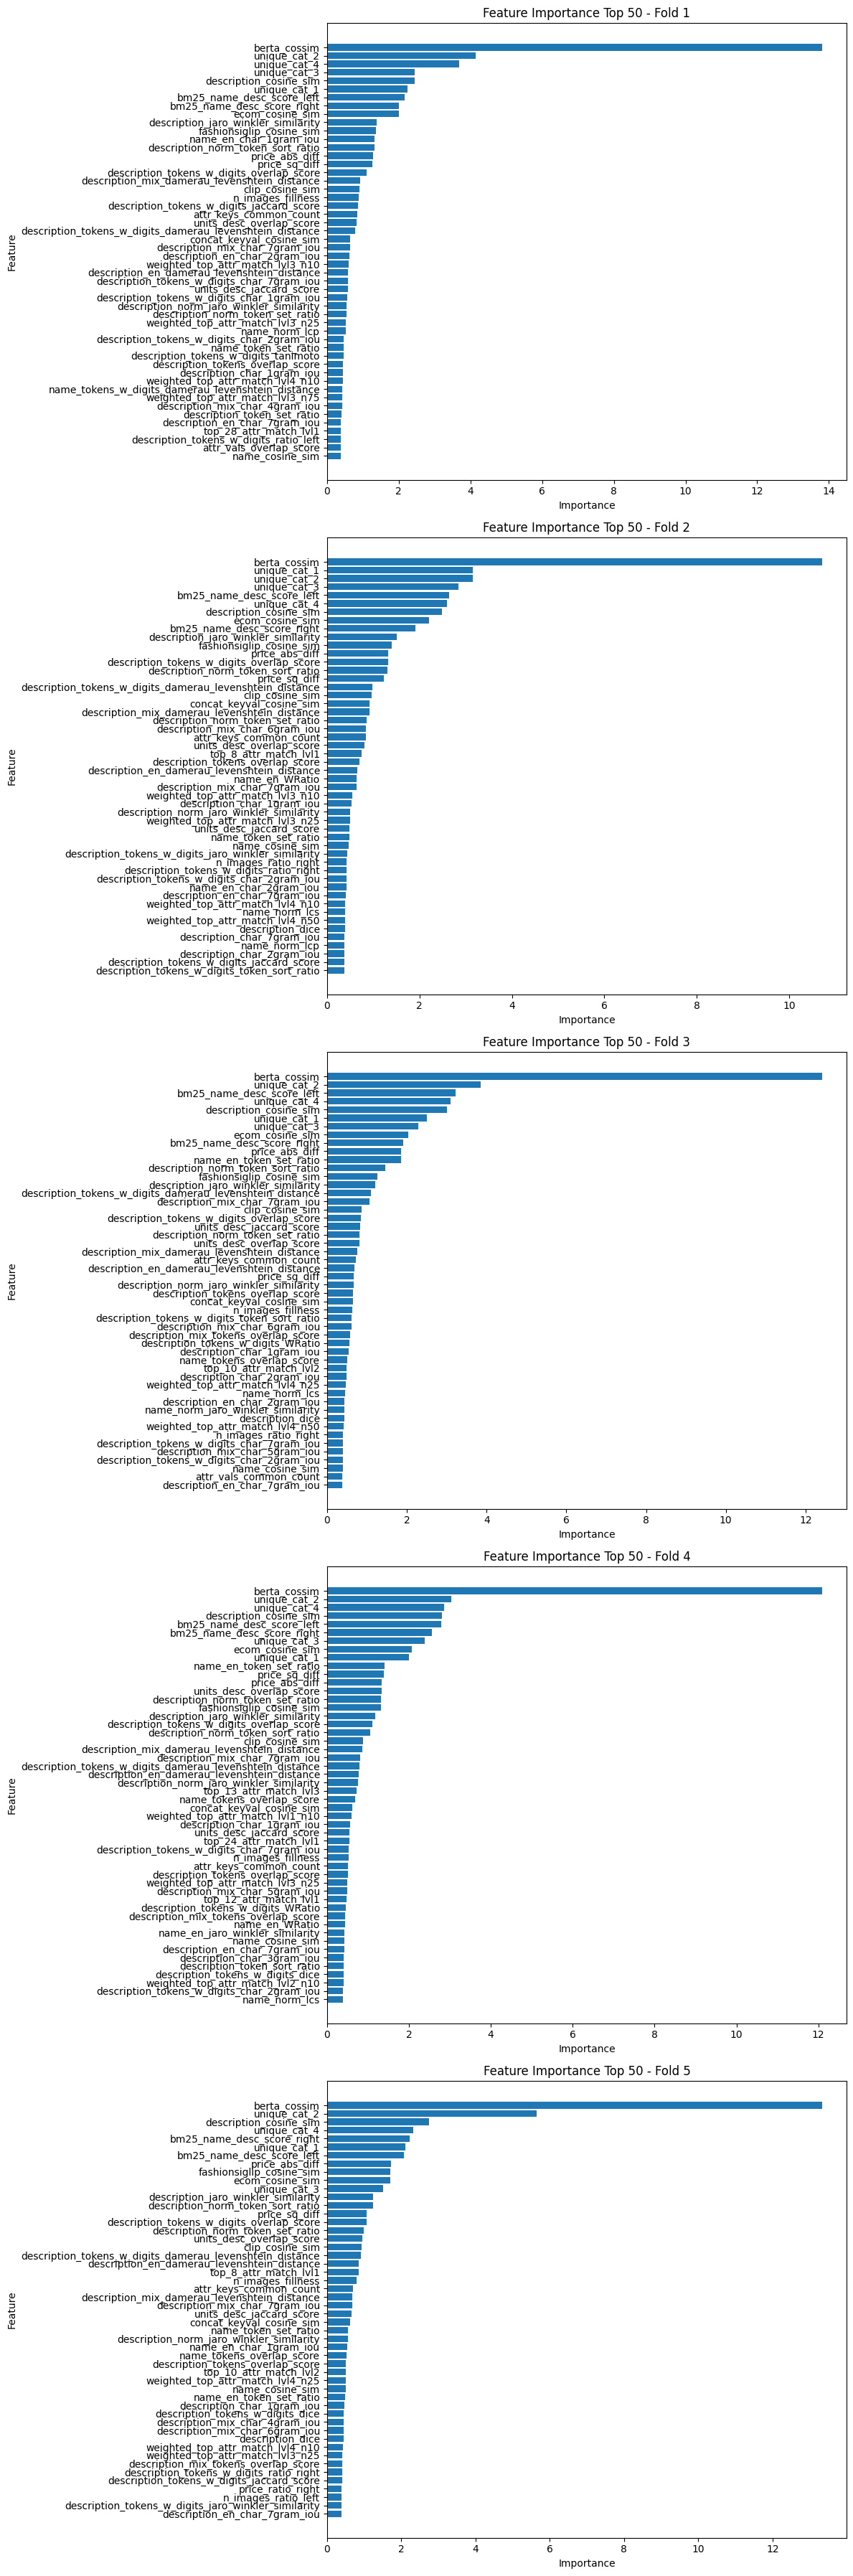

In [35]:
fig, axes = plt.subplots(5, 1, figsize=(12, 36))

for i, model in enumerate(models):
    feature_importances = model.get_feature_importance()
    feature_names = features
    sorted_idx = np.argsort(feature_importances)[::-1][:50]
    top_features = np.array(feature_names)[sorted_idx]
    top_importances = feature_importances[sorted_idx]
    
    axes[i].barh(top_features[::-1], top_importances[::-1])
    axes[i].set_title(f'Feature Importance Top 50 - Fold {i+1}')
    axes[i].set_xlabel('Importance')
    axes[i].set_ylabel('Feature')

plt.tight_layout()
plt.show()